## Library imports, data imports, and initialisations

In [1]:
# Import required libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
%matplotlib inline

import seaborn as sns
color = sns.color_palette()

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import norm, probplot
from sklearn.preprocessing import StandardScaler

# Load in the training and testing datasets
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

## Impute missing values
I've chosen to do this first, so that any effects it has on relationships or other aspects of this exploration/modeling can be accounted for early on.

In [2]:
def getMissingValues():
    missingValuesTotal = df_train.isnull().sum().sort_values(ascending = False)
    missingValuesPercent = (100 * df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending = False)

    missingValues = pd.concat([missingValuesTotal, missingValuesPercent], axis = 1, keys = ['# Missing', '% Missing'])
    return missingValues[missingValues['# Missing'] > 0]

getMissingValues()

,# Missing,% Missing
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageCond,81,5.547945
GarageType,81,5.547945
GarageFinish,81,5.547945


In [3]:
# Fill values in the training and testing datasets for the column specified
def fillMissingValues(var, fill):
    df_train[var] = df_train[var].fillna(fill)
    df_test[var] = df_test[var].fillna(fill)
    
# PoolQC w/ missing values: 99.66%
# In data_description.txt, NaN values indicate there is no pool
fillMissingValues('PoolQC', 'NA')

# MiscFeature w/ missing values: 96.29%
# In data_description.txt, NaN values indicate there are no misc features
fillMissingValues('MiscFeature', 'NA')

# Alley w/ missing values: 93.75%
# In data_description.txt, NaN values indicate there is no alley access
fillMissingValues('Alley', 'NA')

# Fence w/ missing values: 80.76%
# In data_description.txt, NaN values indicate there is no fence
fillMissingValues('Fence', 'NA')

# FireplaceQu w/ missing values: 47.42%
# In data_description.txt, NaN values indicate there is no fireplace
fillMissingValues('FireplaceQu', 'NA')

# LotFrontage w/ missing values: 17.8%
# In data_description.txt, no substitution is given for NaN LotFrontage characteristics; thus I'm going to use the median values for the row's corresponding neighbourhood.
# This may have issues when a there is a NaN value in a neighbourhood with no other samples, but for now this is not the case.
df_train['LotFrontage'] = df_train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# GarageCond, GarageFinish, GarageType, GarageQual, GarageYrBlt w/ missing values: 5.57%;
# In data_description.txt, NaN values indicate there is no garage
for cVar in ['GarageCond', 'GarageType', 'GarageFinish', 'GarageQual']:
    fillMissingValues(cVar, 'NA')
fillMissingValues('GarageYrBlt', 0)

# BsmtExposure, BsmtFinType2 w/ missing values: 2.61%; BsmtCond, BsmtFinType1, BsmtQual w/ missing values: 2.54%
# In data_description.txt, NaN values indicate there is no basement
for cVar in ['BsmtExposure', 'BsmtFinType2', 'BsmtCond', 'BsmtFinType1', 'BsmtQual']:
    fillMissingValues(cVar, 'NA')

# MasVnrArea, MasVnrType w/ missing values: 0.55%
# In data_description.txt, NaN values indicate there is no masonry vaneer
fillMissingValues('MasVnrArea', 0)
fillMissingValues('MasVnrType', 'NA')

# Electrical w/ missing values: 0.07%
# In data_description.txt, no substitution is given for NaN Electrical characteristics; thus I assume the one missing value is an error to be dropped.
df_train = df_train.drop(df_train[df_train['Electrical'].isnull()].index)

# Confirm that all missing values have been fixed
getMissingValues()

,# Missing,% Missing


## Clean data types
Change all categorical columns are as noted as numbers to strings.

In [4]:
cols_numToObj = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt',
                 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']

for col in cols_numToObj:
    df_train[col] = df_train[col].apply(str)
    df_test[col] = df_test[col].apply(str)

## Preliminary correlation inspections
Review correlation values between each set of characteristics, to identify if there are any redundant columns that could be dropped.

Characteristics with significant correlations:
GarageArea    GarageCars     0.882613
TotRmsAbvGrd  GrLivArea      0.825576
1stFlrSF      TotalBsmtSF    0.819393
dtype: float64



<AxesSubplot:>

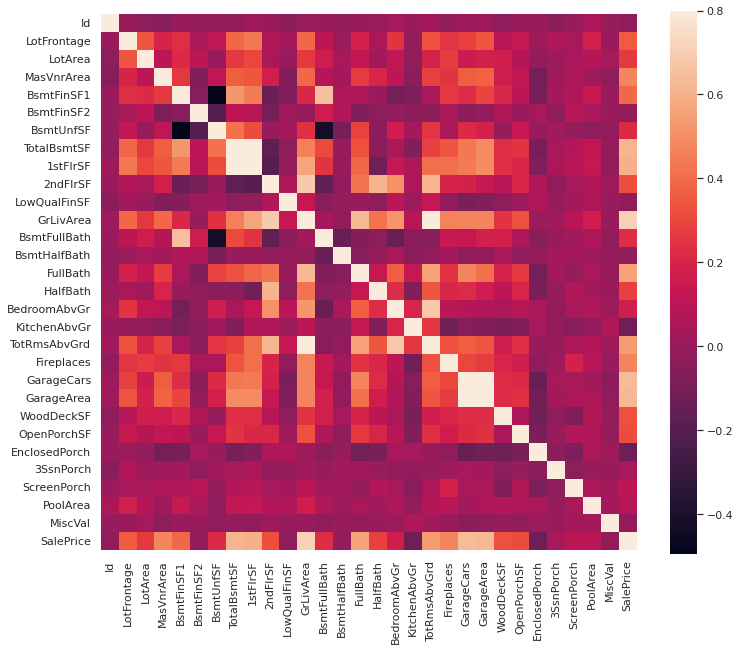

In [5]:
# Correlation matrix for all characteristics
corrMat = df_train.corr()

# Determine which correlations are significant, and drop the others
# Assuming correlation values >= 0.8 are significant
corrValues = corrMat.unstack().abs()
c = [corrValues.drop(i, inplace = True) for i, v in corrValues.items()
     if i[0] == i[1]                           # left and right index are the same
     or v < 0.8                                # Value is insignificant
     or (i[1], i[0]) in corrValues.index]      # repeated correlation values

# Sort and print the correlation values
print('Characteristics with significant correlations:\n{}\n'.format(corrValues.sort_values(ascending = False)))

# Print the figure
sns.set(font_scale = 1.0, rc = {'figure.figsize': (12, 10)})
sns.heatmap(corrMat, vmax = 0.8, square = True)

Very strong correlations between the following:
* GarageArea & GarageCars
* TotRmsAbvGrd & GrLivArea
* 1stFlrSF & TotalBsmtSF

I'll check which characteristic in each of the above pairs has a stronger correlation with SalePrice, and remove the other column.

Characteristics with correlation values over 0.5:
GrLivArea       0.708618
GarageCars      0.640473
GarageArea      0.623423
TotalBsmtSF     0.613905
1stFlrSF        0.605968
FullBath        0.560881
TotRmsAbvGrd    0.533779
Name: SalePrice, dtype: float64



<AxesSubplot:>

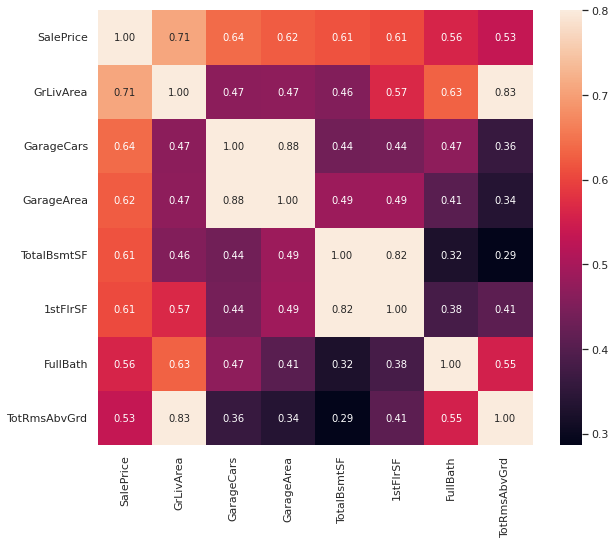

In [6]:
# Saleprice correlation matrix
#     Only including characteristics with correlation values over corrMin (relative to SalePrice)

corrMin = 0.5
corrSalePrice = corrMat[corrMat['SalePrice'].abs() >= corrMin]['SalePrice'].sort_values(ascending = False)
print('Characteristics with correlation values over {}:\n{}\n'.format(corrMin, corrSalePrice.drop('SalePrice')))

cols = corrSalePrice.index
cm = np.corrcoef(df_train[cols].values.T)

sns.set(font_scale = 1.0, rc = {'figure.figsize': (10, 8)})
sns.heatmap(cm, cbar = True, annot = True, square = True,
            fmt = '0.2f', annot_kws = {'size': 10}, vmax = 0.8,
            xticklabels = cols.values, yticklabels = cols.values)

Referring to the previous strong correlations between characteristics (not inc. SalePrice):
* GarageArea (0.623423) & GarageCars (0.640473)
* TotRmsAbvGrd (0.533779) & GrLivArea (0.708618)
* 1stFlrSF (0.605968) & TotalBsmtSF (0.613905)

Therefore the following columns will be removed:
* GarageArea
* TotRmsAbvGrd
* 1stFlrSF

In [7]:
df_train = df_train.drop(columns = ['GarageArea', 'TotRmsAbvGrd', '1stFlrSF'])
df_test = df_test.drop(columns = ['GarageArea', 'TotRmsAbvGrd', '1stFlrSF'])

And the following characteristics are worth exploring further:
* GrLivArea
* GarageCars
* TotalBsmtSF
* FullBath

## Initial data exploration

In [8]:
# Check the size of the datasets
print('Size of the training dataset: {}'.format(df_train.shape))
print('Size of the testing dataset: {}\n'.format(df_test.shape))

# Make sure there are no zero-values in the SalePrice column
df_train['SalePrice'].describe()

Size of the training dataset: (1459, 78)
Size of the testing dataset: (1459, 77)



count      1459.000000
mean     180930.394791
std       79468.964025
min       34900.000000
25%      129950.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

There are no zero-values, which is great for modelling. However, the results above indicate that there will be a right skew.

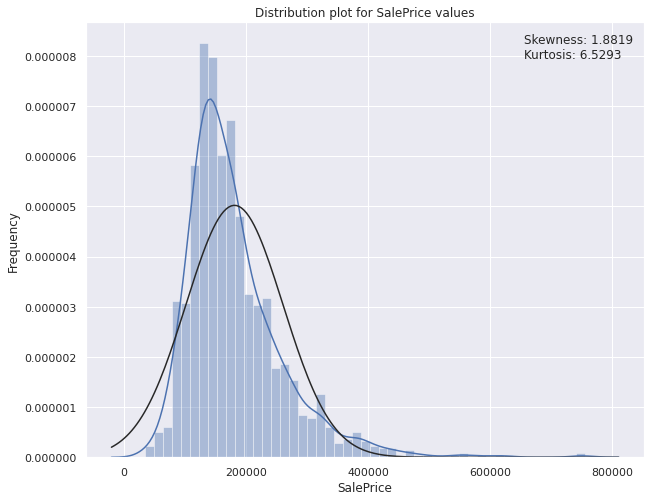

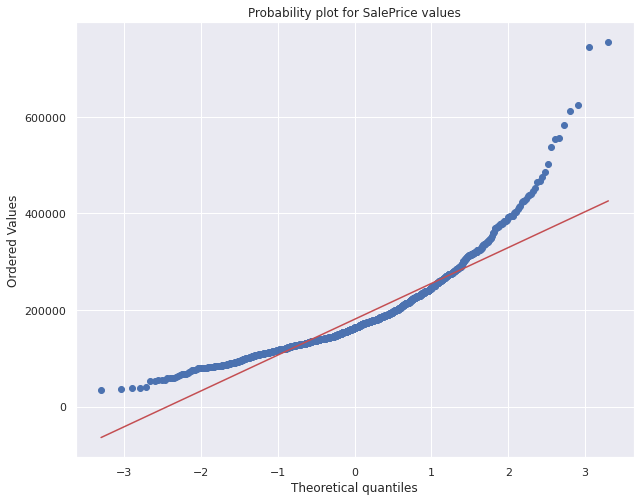

In [9]:
# Making these into functions for use later one

# Generate histogram, and print values for skewness and kurtosis on it
def histogramPlot(var):
    fig, ax = plt.subplots()
    sns.distplot(df_train[var], fit = norm)
    plt.ticklabel_format(style = 'plain', axis = 'y')
    plt.title('Distribution plot for {} values'.format(var))
    plt.ylabel('Frequency')
    ax.add_artist(AnchoredText('Skewness: {:.4f}\nKurtosis: {:.4f}\n'.format(df_train[var].skew(), df_train[var].kurt()),
                               loc = 'upper right', frameon = False))
    plt.show()

# Generate probability plot (QQ-plot)
def probabilityPlot(var):
    fig = plt.figure()
    res = probplot(df_train[var], plot = plt)
    plt.title('Probability plot for {} values'.format(var))
    plt.show()
    
histogramPlot('SalePrice')
probabilityPlot('SalePrice')

Right skew (positive) confirmed. Noted for later, so that I can apply log transformations to normalise SalePrice (and likely other numeric characteristics).

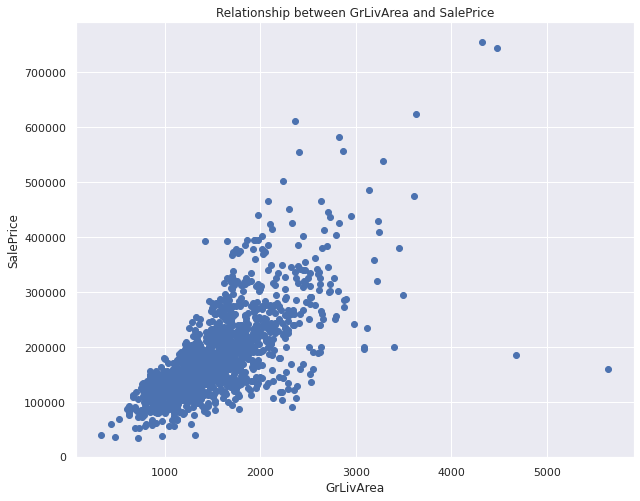

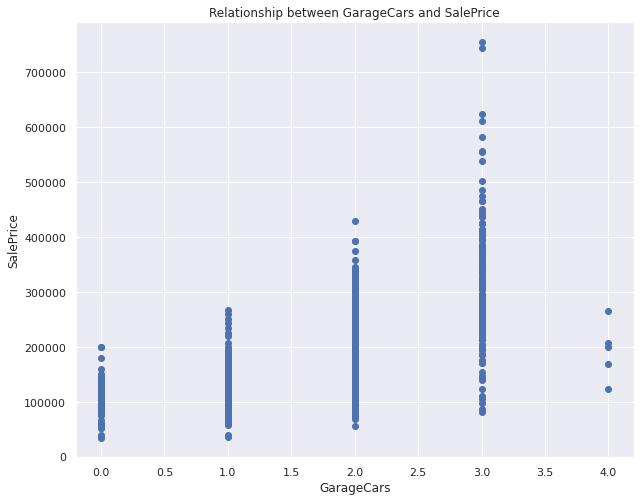

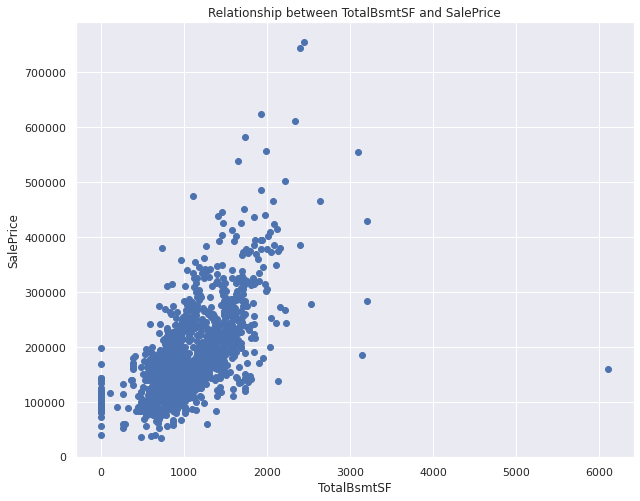

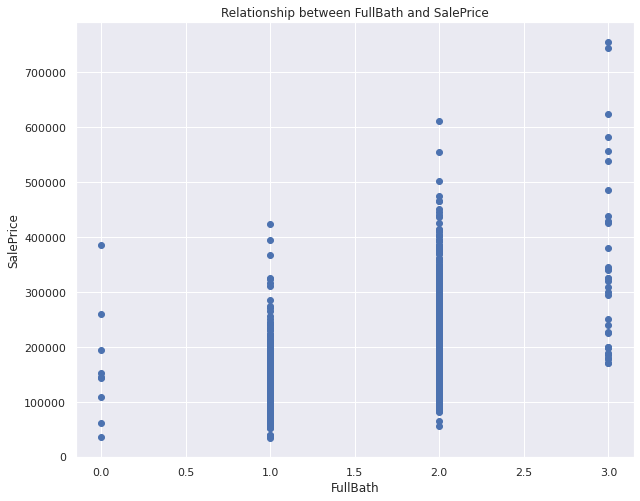

In [10]:
# Making this into a function for use later one
def scatterPlot(xVar, yVar):
    plt.scatter(x = df_train[xVar], y = df_train[yVar])
    plt.title('Relationship between {} and {}'.format(xVar, yVar))
    plt.xlabel(xVar)
    plt.ylabel(yVar)
    plt.show()
    
# Numerical values
variables = ['GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath']
for var in variables:
    scatterPlot(var, 'SalePrice')
    
# Categorical variables
#variables = ['OverallQual', 'YearBuilt', 'YearRemodAdd']
#for var in variables:
#    sns.boxplot(x = df_train[var], y = df_train['SalePrice'])
#    plt.title('Relationship between {} and {}'.format(var, 'SalePrice'))
#    plt.xlabel(var)
#    plt.ylabel('SalePrice')
#    plt.xticks(rotation = 90)
#    plt.show()

The relationships are as expected, though there are some outliers to remove. Whilst removing data can be hazardous, GrLivArea and TotalBsmtSF have obvious outliers to the right of the plot, and these will be excluded. However, I'll ignore outliers in characteristics not mentioned above (because their correlation to SalePrice is much lower, their outliers shouldn't have as much negative impact).

In [11]:
# Two outliers within the GrLivArea characteristic
df_train = df_train.drop(df_train[(df_train['GrLivArea'] > 4500) & (df_train['SalePrice'] < 200000)].index)

# One outlier within the TotalBsmtSF characteristic
df_train = df_train.drop(df_train[(df_train['TotalBsmtSF'] > 6000) & (df_train['SalePrice'] < 200000)].index)

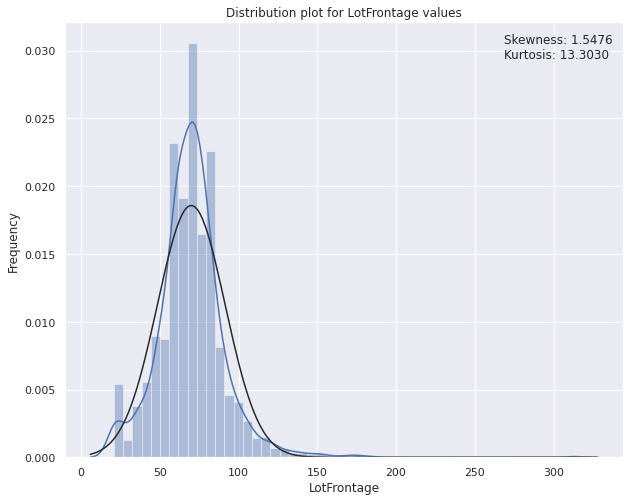

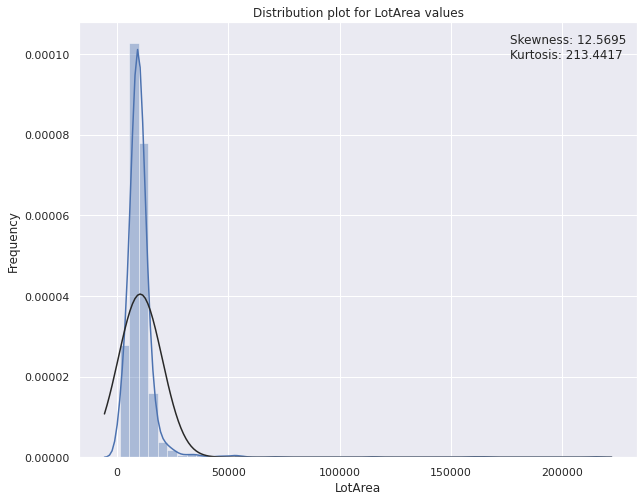

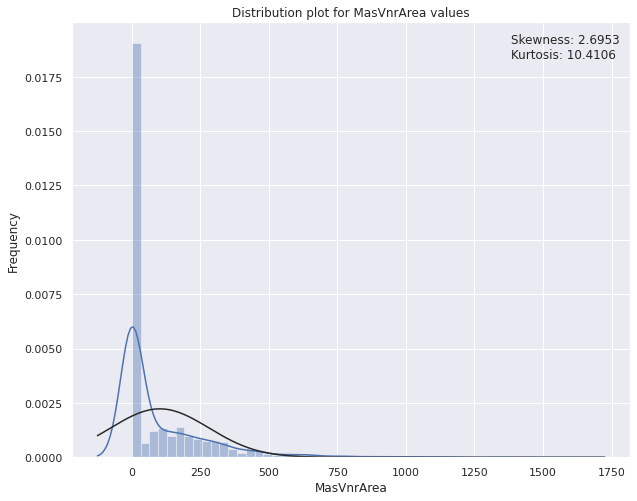

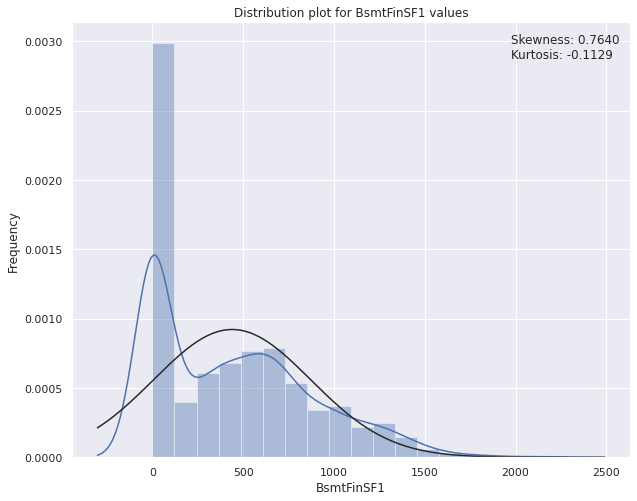

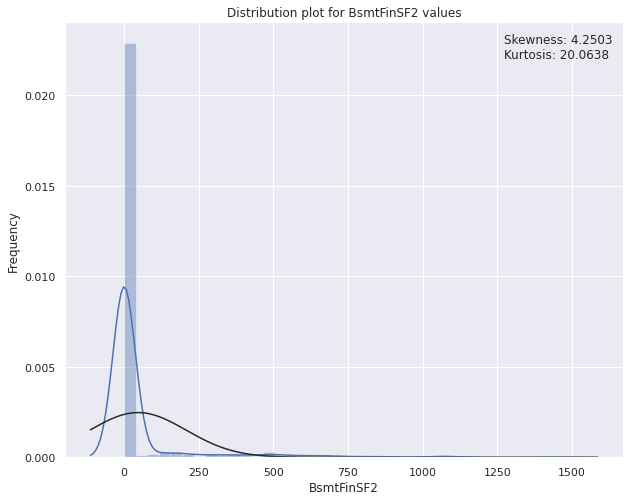

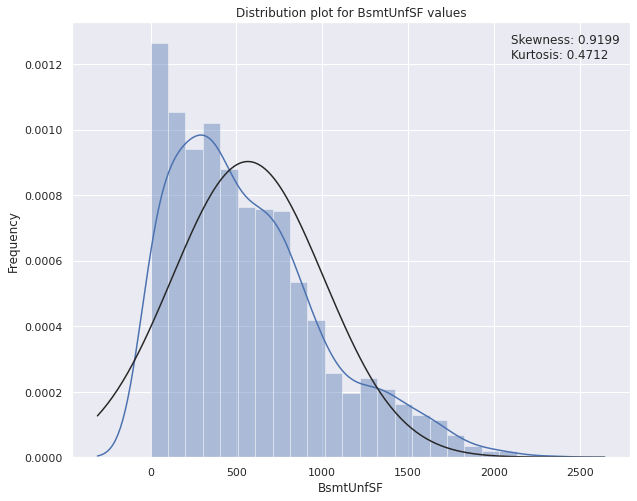

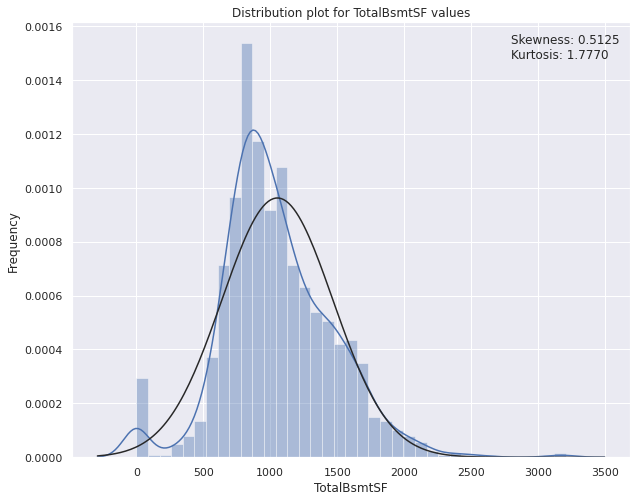

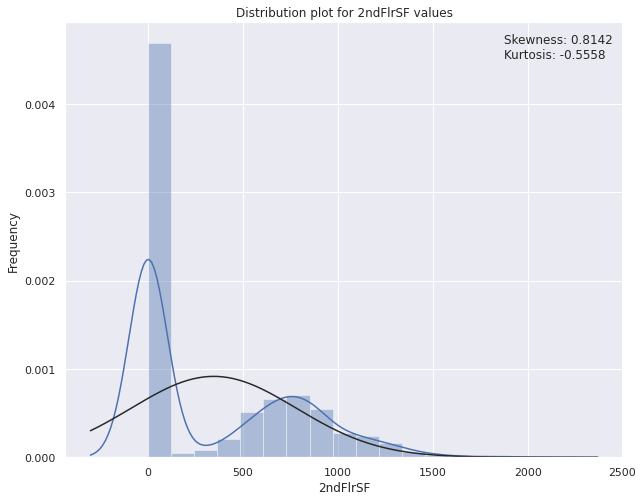

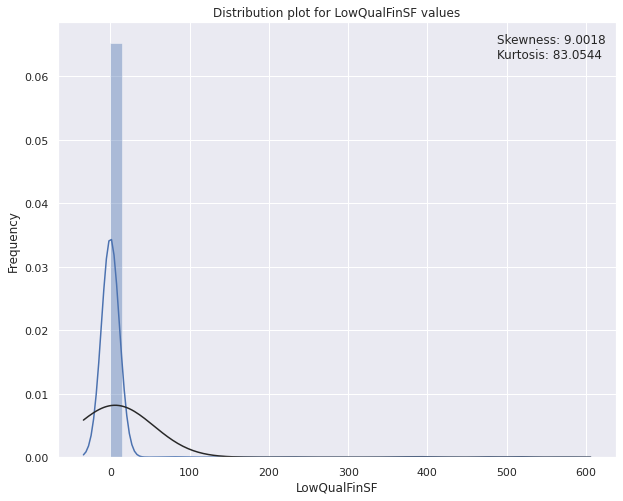

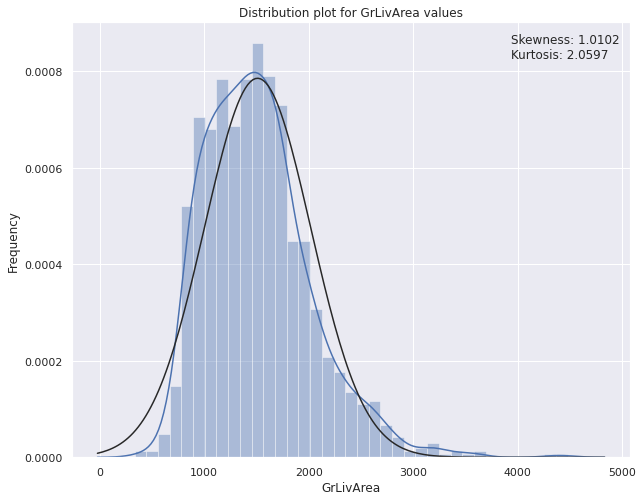

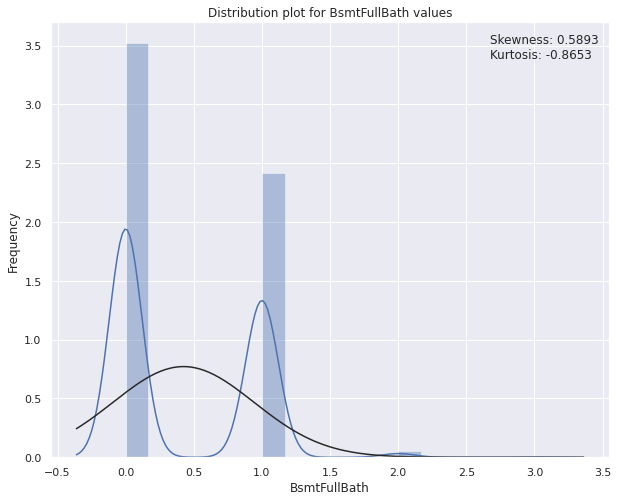

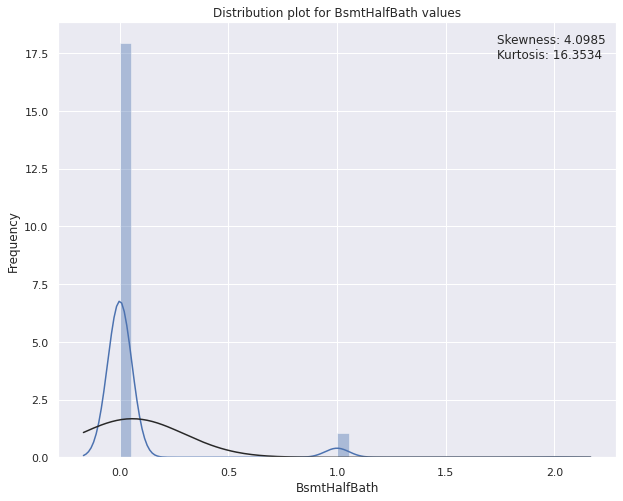

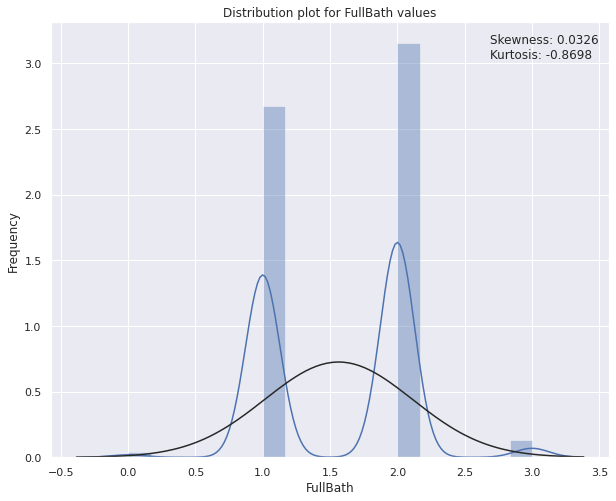

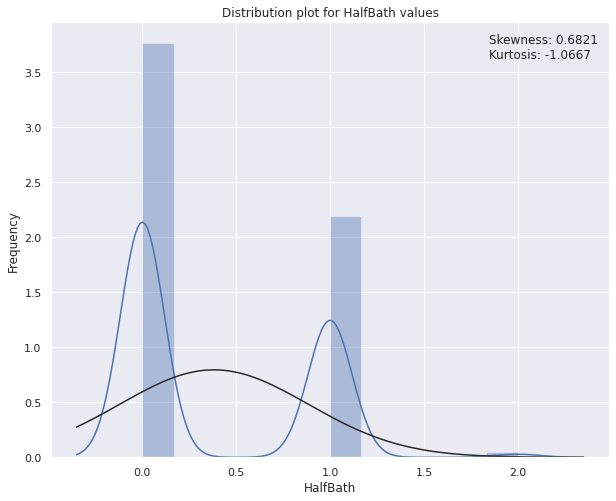

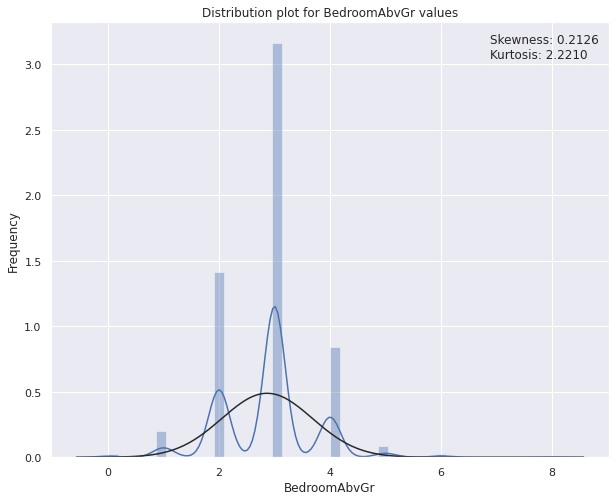

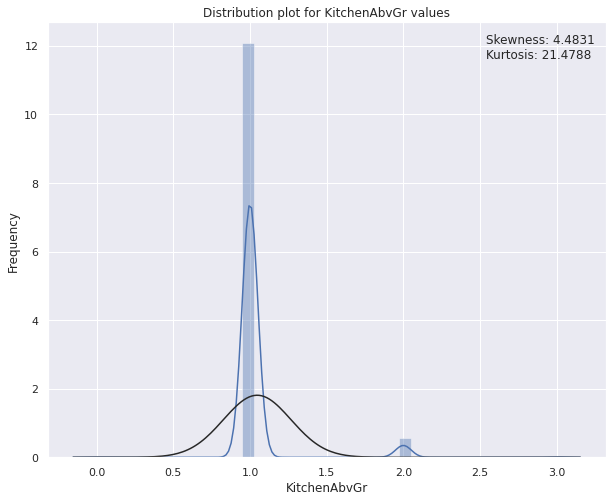

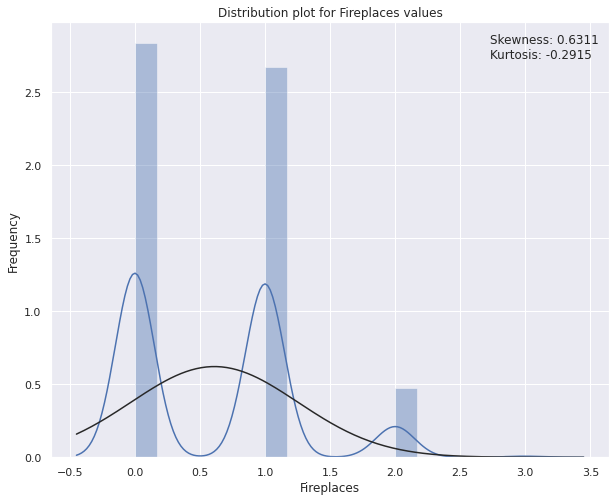

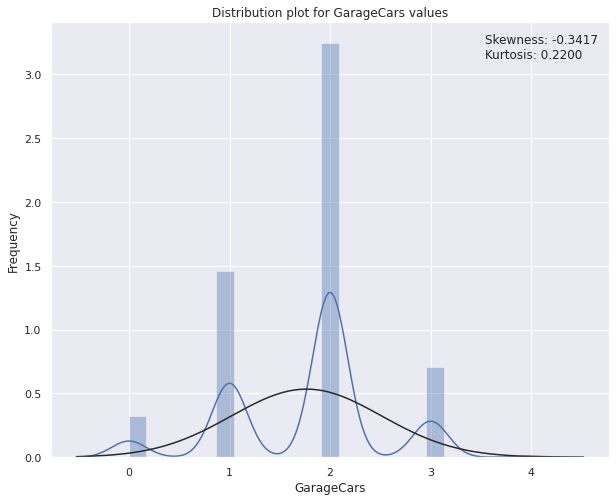

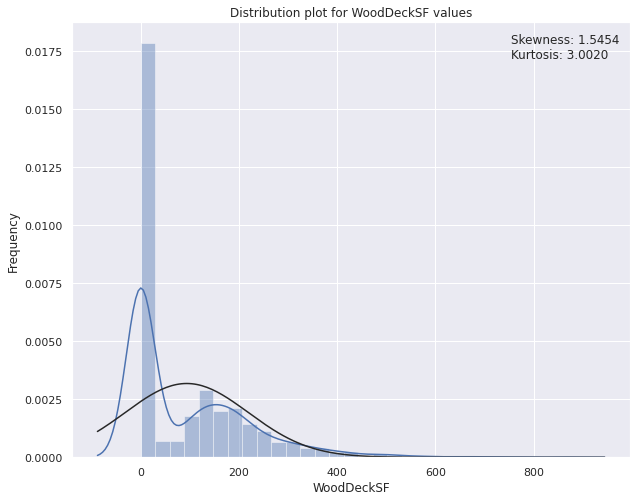

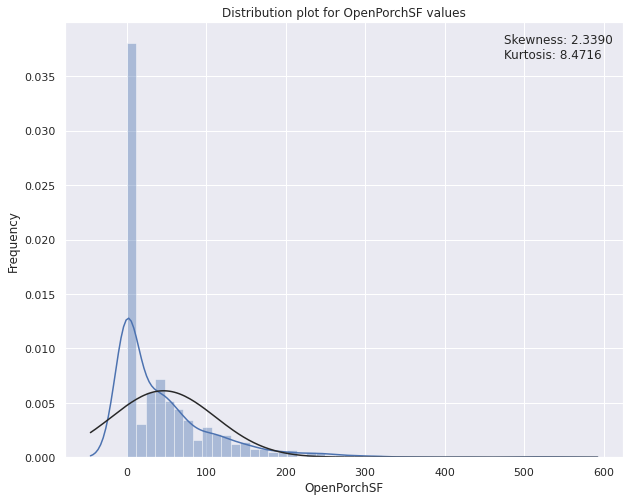

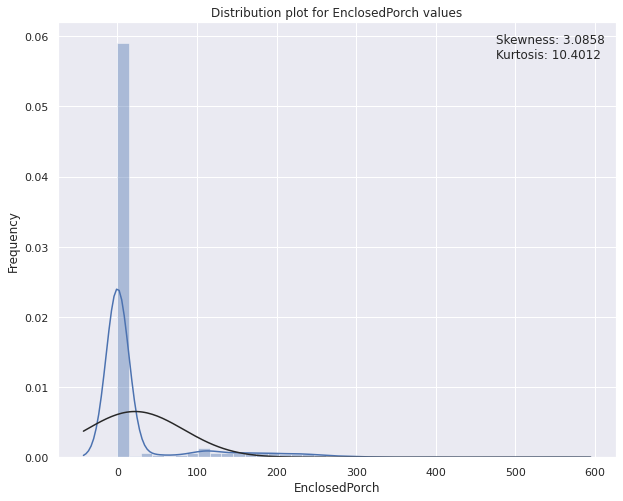

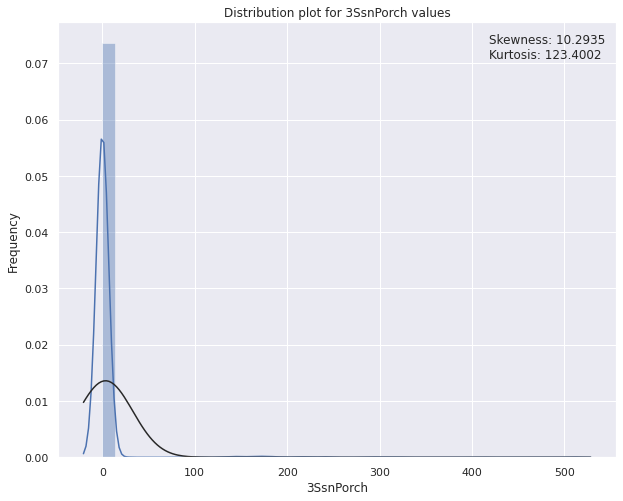

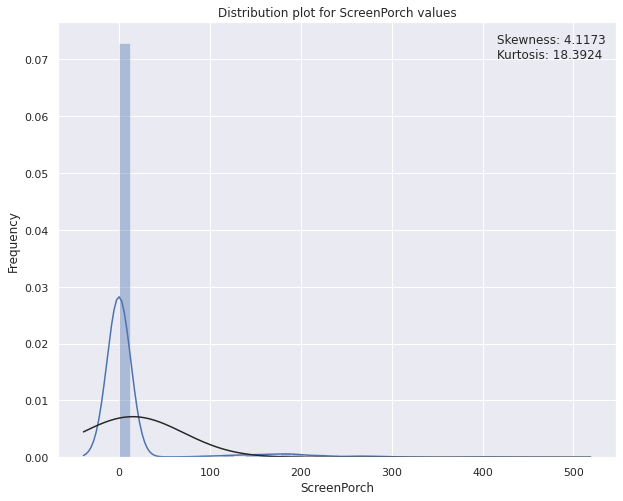

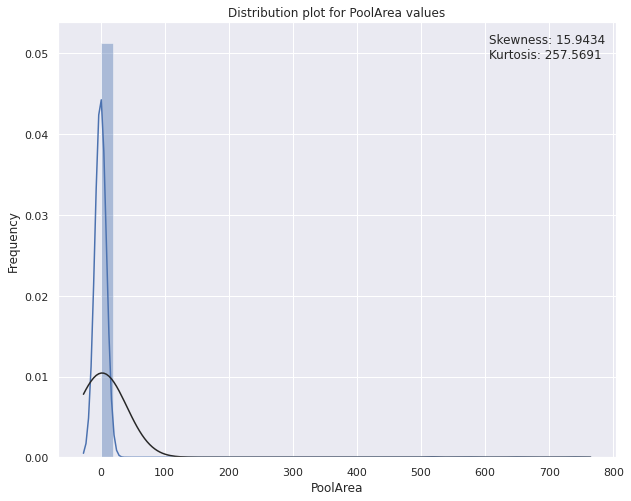

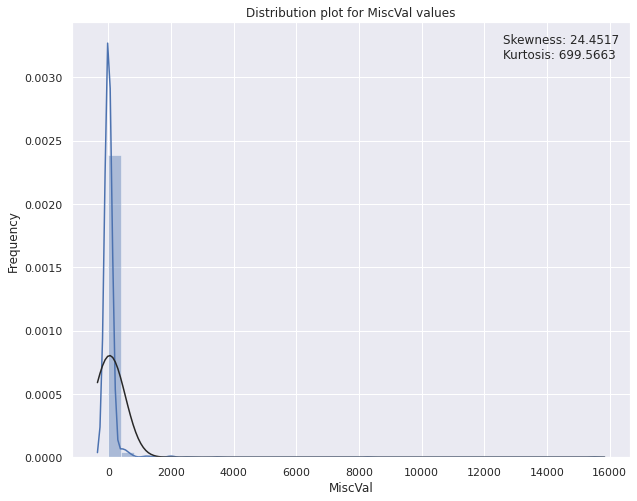

In [12]:
types = df_train.dtypes
types = types[(types != 'object') & (~types.index.isin(['Id', 'SalePrice']))]

for var, t in types.items():
    histogramPlot(var)